In [230]:
import json
from numpy import *
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import ticker
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [231]:
def build_vocab(texts, n=None):
    counter = Counter(''.join(texts))  # char level
    char2index = {w: i for i, (w, c) in enumerate(counter.most_common(n), start=4)}
    char2index['~'] = 0
    char2index['^'] = 1
    char2index['$'] = 2
    char2index['#'] = 3
    index2char = {i: w for w, i in char2index.items()}
    return char2index, index2char

In [232]:
pairs = json.load(open('Time Dataset.json', 'rt', encoding='utf-8'))

In [233]:
data = array(pairs)
src_texts = data[:, 0]
trg_texts = data[:, 1]
src_c2ix, src_ix2c = build_vocab(src_texts)
trg_c2ix, trg_ix2c = build_vocab(trg_texts)

In [234]:
def indexes_from_text(text, char2index):
    return [char2index[c] for c in text] + [2]
def pad_seq(seq, max_length):
    seq += [0 for _ in range(max_length - len(seq))]
    return seq

max_src_len = max(list(map(len, src_texts))) + 1
max_trg_len = max(list(map(len, trg_texts))) + 1
max_src_len, max_trg_len

(42, 6)

In [235]:
def random_batch(batch_size, pairs, src_c2ix, trg_c2ix):
    input_seqs, target_seqs = [], []

    for i in random.choice(len(pairs), batch_size):
        input_seqs.append(indexes_from_text(pairs[i][0], src_c2ix))
        target_seqs.append(indexes_from_text(pairs[i][1], trg_c2ix))

    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    input_var = torch.LongTensor(input_padded).transpose(0, 1)  
    # seq_len x batch_size
    target_var = torch.LongTensor(target_padded).transpose(0, 1)
    input_var = input_var.to(device)
    target_var = target_var.to(device)

    return input_var, input_lengths, target_var, target_lengths

In [236]:
def attention(query, key, value):
    """query[B, H], key[B, L, H], value[B, L, H]"""
    query = query.unsqueeze(1).repeat(1, key.size(1), 1)
    # (B, L, H)
    score = torch.sum(query * key, -1)
    attn = F.softmax(score, -1).unsqueeze(1)
    # (B, 1, L)
    outputs = torch.matmul(attn, value)
    return outputs.squeeze(1), attn.squeeze(1)

In [237]:
class Seq2seq(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.encoder_embedding = nn.Embedding(input_dim, embedding_dim)
        self.decoder_embedding = nn.Embedding(output_dim, embedding_dim)
        self.encoder = nn.GRU(embedding_dim, hidden_dim)
        self.decoder = nn.GRUCell(embedding_dim, hidden_dim)
        self.fc = nn.Linear(embedding_dim + hidden_dim * 2, output_dim)
    
    def forward(self, inputs, targets):
        batch_size = inputs.size(1)
        max_len = targets.size(0)
        # (L, B)
        embedded = self.encoder_embedding(inputs)
        targets = self.decoder_embedding(targets)
        # (L, B, E)
        encoder_outputs, hidden = self.encoder(embedded)
        # initialize 
        decoder_outputs = torch.zeros(max_len, batch_size, self.output_dim).to(device)
        decoder_input = torch.zeros((batch_size, self.embedding_dim)).to(device)
        hidden = hidden.squeeze(0) # (B, H)
        for i in range(max_len):
            hidden = self.decoder(decoder_input, hidden)
            # (B, H)
            context, _ = attention(hidden, encoder_outputs.transpose(0, 1), encoder_outputs.transpose(0, 1))
            output = F.log_softmax(F.relu(self.fc(torch.cat((decoder_input, hidden, context), 1))), 1)
            decoder_outputs[i] = output
            decoder_input = targets[i]

        return decoder_outputs
    
    def predict(self, inputs, max_trg_len):
        batch_size = inputs.size(1)
        max_src_len = inputs.size(0)
        # (L, B)
        embedded = self.encoder_embedding(inputs)
        # (L, B, E)
        encoder_outputs, hidden = self.encoder(embedded)
        # initialize 
        decoder_outputs = torch.zeros(max_trg_len, batch_size, self.output_dim).to(device)
        decoder_input = torch.zeros((batch_size, self.embedding_dim)).to(device)
        attn_weights = torch.zeros((max_trg_len, batch_size, max_src_len)).to(device)
        hidden = hidden.squeeze(0) # (B, H)
        for i in range(max_trg_len):
            hidden = self.decoder(decoder_input, hidden)
            # (B, H)
            context, attn_weight = attention(hidden, encoder_outputs.transpose(0, 1), encoder_outputs.transpose(0, 1))
            output = F.log_softmax(F.relu(self.fc(torch.cat((decoder_input, hidden, context), 1))), 1)
            decoder_outputs[i] = output
            _, indices = torch.max(output, 1)
            decoder_input = self.decoder_embedding(indices)
            attn_weights[i] = attn_weight
        return decoder_outputs, attn_weights

In [238]:
embedding_dim = 100
hidden_dim = 100
batch_size = 256
clip = 5
model = Seq2seq(len(src_c2ix)+1, len(trg_c2ix)+1, embedding_dim, hidden_dim).to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.NLLLoss(ignore_index=0).to(device)

model.train()
for batch_id in range(1, 2001):
    src_seqs, _, trg_seqs, _ = random_batch(batch_size, pairs, src_c2ix, trg_c2ix)
    
    optimizer.zero_grad()
    output = model(src_seqs, trg_seqs)
    loss = criterion(output.view(-1, output.shape[2]), trg_seqs.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    if batch_id % 100 == 0:
        print('current loss: {:.4f}'.format(loss))

current loss: 0.8925
current loss: 0.5474
current loss: 0.3475
current loss: 0.2679
current loss: 0.2080
current loss: 0.1273
current loss: 0.1008
current loss: 0.0785
current loss: 0.0659
current loss: 0.0445
current loss: 0.0497
current loss: 0.0419
current loss: 0.0277
current loss: 0.0203
current loss: 0.0287
current loss: 0.0239
current loss: 0.0093
current loss: 0.0055
current loss: 0.0109
current loss: 0.0158


In [239]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator())

    plt.show()
    plt.close()

def evaluate(model, text, src_c2ix, trg_ix2c):
    model.eval()
    with torch.no_grad():
        seq = torch.LongTensor(indexes_from_text(text, src_c2ix)).view(-1, 1).to(device)
        outputs, attn_weights = model.predict(seq, max_trg_len)
        outputs = outputs.squeeze(1).cpu().numpy()
        output_words = [trg_ix2c[np.argmax(word_prob)] for word_prob in outputs]
        print(''.join(output_words))
        show_attention(list(text), output_words, attn_weights.squeeze(1).cpu().numpy())

07:54$


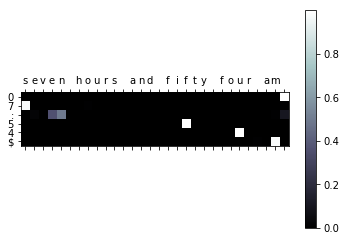

In [240]:
text = 'seven hours and fifty four am'
evaluate(model, text, src_c2ix, trg_ix2c)